<a href="https://colab.research.google.com/github/kinome79/Colaborator/blob/main/Copy_of_fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2023-02-27 14:56:36--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.003s  

2023-02-27 14:56:36 (14.2 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
# View the dataset information
print(dataset.info(), "-----------------------------\n\n")
print(dataset.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None -----------------------------


               age          bmi     children      expenses
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.665471     1.094918  13270.422414
std      14.049960     6.098382     1.205493  12110.011240
min      18.000000    16.000000     0.000000   1121.870000
25%      27.000000    26.300000     0.000000   4740.287500
50%      39.000000    30.400000     1.000000   9382.030000
75%      51.000000    34.70000

In [15]:
# Check Categorical Values

print("Sex Categories:", dataset['sex'].unique(),'\n'+ str(dataset['sex'].value_counts()), '\n')
print("Smoker Categories:", dataset['smoker'].unique(),'\n'+ str(dataset['smoker'].value_counts()), '\n')
print("Region Categories:", dataset['region'].unique(),'\n'+ str(dataset['region'].value_counts()), '\n')


Sex Categories: ['female' 'male'] 
male      676
female    662
Name: sex, dtype: int64 

Smoker Categories: ['yes' 'no'] 
no     1064
yes     274
Name: smoker, dtype: int64 

Region Categories: ['southwest' 'southeast' 'northwest' 'northeast'] 
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64 



In [48]:
# Convert Categorical Values (maintaining original dataframe)

df_data = dataset.copy(deep=True)
df_data['sex'].replace(['male','female'], [0,1], inplace=True)
df_data['smoker'].replace(['no','yes'], [0,1], inplace=True)
df_data['region'].replace(['southeast','southwest','northwest','northeast'],[0,1,2,3], inplace=True)

print("Sex Categories:", df_data['sex'].unique(),'\n'+ str(df_data['sex'].value_counts()), '\n')
print("Smoker Categories:", df_data['smoker'].unique(),'\n'+ str(df_data['smoker'].value_counts()), '\n')
print("Region Categories:", df_data['region'].unique(),'\n'+ str(df_data['region'].value_counts()), '\n')

Sex Categories: [1 0] 
0    676
1    662
Name: sex, dtype: int64 

Smoker Categories: [1 0] 
0    1064
1     274
Name: smoker, dtype: int64 

Region Categories: [1 0 2 3] 
0    364
1    325
2    325
3    324
Name: region, dtype: int64 



<AxesSubplot:>

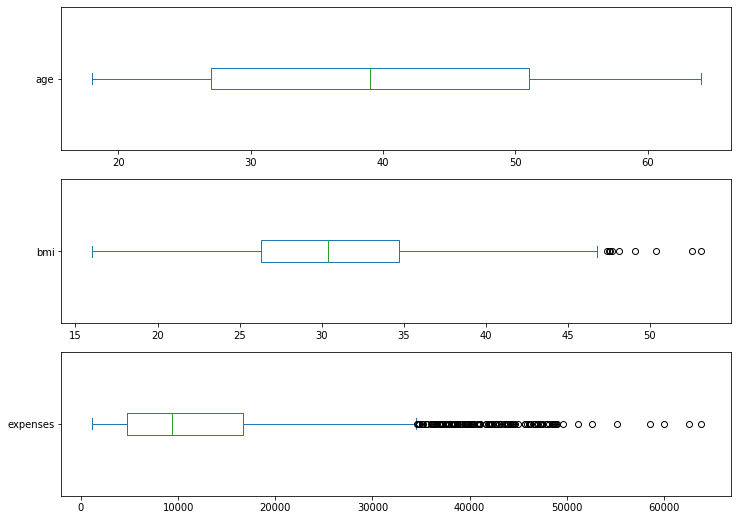

In [49]:
# Check distributions, although describe shows all looks in order

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
df_data['age'].plot(kind='box', vert=False, ax=axes[0])
df_data['bmi'].plot(kind='box', vert=False, ax=axes[1])
df_data['expenses'].plot(kind='box', vert=False, ax=axes[2])

Number of rows remaining after outlier removal: 1311


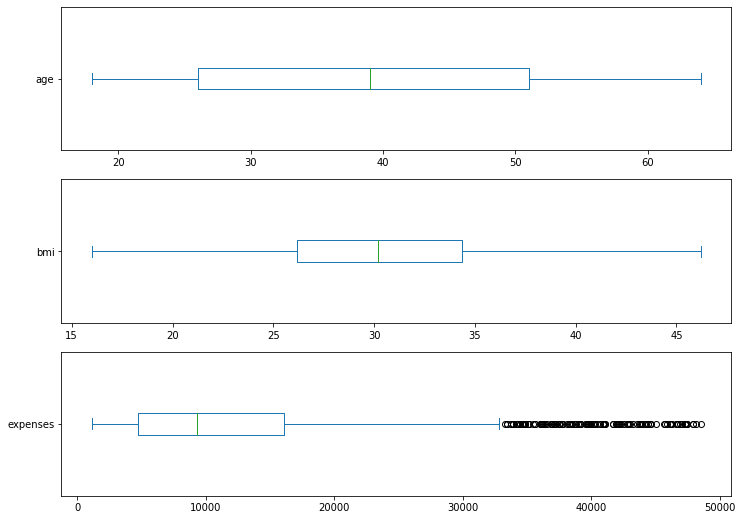

In [65]:
# Removing the top 1% of outliers for expenses and bmi, keeping original data in case this affects accuracy negatively

df_data_f = df_data[df_data['bmi'].le(df_data['bmi'].quantile(0.99)) & df_data['expenses'].le(df_data['expenses'].quantile(0.99))] 

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
df_data_f['age'].plot(kind='box', vert=False, ax=axes[0])
df_data_f['bmi'].plot(kind='box', vert=False, ax=axes[1])
df_data_f['expenses'].plot(kind='box', vert=False, ax=axes[2])

print("Number of rows remaining after outlier removal:", df_data_f.shape[0])

In [83]:
# Build datasets for learning/testing - 20% test data will be every 5th value

train_dataset = df_data_f[df_data_f.index % 5 != 0]
test_dataset = df_data_f[df_data_f.index % 5 == 0]

print(train_dataset)
print(test_dataset)


      age  sex   bmi  children  smoker  region  expenses
1      18    0  33.8         1       0       0   1725.55
2      28    0  33.0         3       0       0   4449.46
3      33    0  22.7         0       0       2  21984.47
4      32    0  28.9         0       0       2   3866.86
6      46    1  33.4         1       0       0   8240.59
...   ...  ...   ...       ...     ...     ...       ...
1332   52    1  44.7         3       0       1  11411.69
1333   50    0  31.0         3       0       2  10600.55
1334   18    1  31.9         0       0       3   2205.98
1336   21    1  25.8         0       0       1   2007.95
1337   61    1  29.1         0       1       2  29141.36

[1050 rows x 7 columns]
      age  sex   bmi  children  smoker  region  expenses
0      19    1  27.9         0       1       1  16884.92
5      31    1  25.7         0       0       0   3756.62
10     25    0  26.2         0       0       3   2721.32
15     19    0  24.6         1       0       1   1837.24
20    

In [84]:
# Separate expenses column out of the training and test datasets

train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

print("Original Train Dataset:\n")
print(df_data_f.iloc[1:4], "\n----------------------------------------------\nNew Train Dataset:\n")
print(train_dataset.head(3), "\n-----------------------------------------------\nNew Label Dataset:\n")
print(train_labels.head(3), "\n-------------------------------")


Original Train Dataset:

   age  sex   bmi  children  smoker  region  expenses
1   18    0  33.8         1       0       0   1725.55
2   28    0  33.0         3       0       0   4449.46
3   33    0  22.7         0       0       2  21984.47 
----------------------------------------------
New Train Dataset:

   age  sex   bmi  children  smoker  region
1   18    0  33.8         1       0       0
2   28    0  33.0         3       0       0
3   33    0  22.7         0       0       2 
-----------------------------------------------
New Label Dataset:

1     1725.55
2     4449.46
3    21984.47
Name: expenses, dtype: float64 
-------------------------------


In [92]:
# Build and compile model for predictions

# Create normalization layer for the data
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_dataset))

# Build the model 
model = tf.keras.Sequential()
model.add(normalizer)
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

# Compile Model with metrics for testing
model.compile(loss='mean_absolute_error', metrics=['mae','mse'], optimizer=keras.optimizers.Adam(0.001))


In [93]:
# Train the model with the training data
hist = model.fit(train_dataset, train_labels, validation_split=0.2, verbose=2, epochs=100)

Epoch 1/100
27/27 - 1s - loss: 13030.1777 - mae: 13030.1777 - mse: 305778752.0000 - val_loss: 13305.3145 - val_mae: 13305.3145 - val_mse: 311321664.0000 - 1s/epoch - 47ms/step
Epoch 2/100
27/27 - 0s - loss: 13027.6572 - mae: 13027.6572 - mse: 305707968.0000 - val_loss: 13301.7012 - val_mae: 13301.7012 - val_mse: 311218848.0000 - 90ms/epoch - 3ms/step
Epoch 3/100
27/27 - 0s - loss: 13022.4473 - mae: 13022.4473 - mse: 305567360.0000 - val_loss: 13294.2832 - val_mae: 13294.2832 - val_mse: 311009312.0000 - 84ms/epoch - 3ms/step
Epoch 4/100
27/27 - 0s - loss: 13012.3252 - mae: 13012.3252 - mse: 305289632.0000 - val_loss: 13280.7158 - val_mae: 13280.7158 - val_mse: 310632512.0000 - 82ms/epoch - 3ms/step
Epoch 5/100
27/27 - 0s - loss: 12994.6367 - mae: 12994.6367 - mse: 304814816.0000 - val_loss: 13258.1152 - val_mae: 13258.1152 - val_mse: 310007680.0000 - 82ms/epoch - 3ms/step
Epoch 6/100
27/27 - 0s - loss: 12966.5752 - mae: 12966.5752 - mse: 304067776.0000 - val_loss: 13223.7988 - val_mae: 

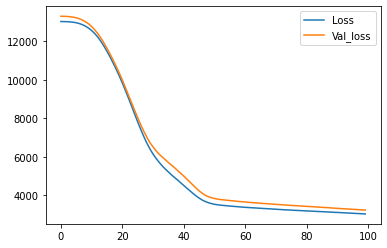

In [97]:
# Review loss history
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Val_loss')
plt.legend()


9/9 - 0s - loss: 2773.8401 - mae: 2773.8401 - mse: 30740522.0000 - 53ms/epoch - 6ms/step
Testing set Mean Abs Error: 2773.84 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 3ms/step


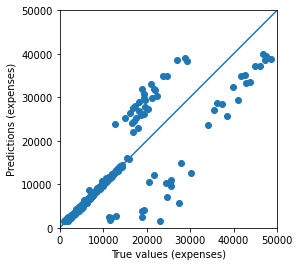

In [98]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
